# Biblioteca XGBoost

Internamente, o funcionamento do XGBoost é complicado e não foi dado muitos detalhes no curso. O StatQuest tem 4 vídeos explicando o XGBoost, mas mesmo assim é difícil de entender e envolve um bom conhecimento em estatística e matemática. Vale a pena como referência:

- [XGBoost Regressão](https://www.youtube.com/watch?v=OtD8wVaFm6E)

- [XGBoost Classificação](https://www.youtube.com/watch?v=8b1JEDvenQU)

- [XGBoost Equações](https://www.youtube.com/watch?v=ZVFeW798-2I)

- [XGBoost Otimizações](https://www.youtube.com/watch?v=oRrKeUCEbq8)

Neste curso, vamos trabalhar com dados da área médica, para criar um modelo que classifique pacientes como portadores ou não de uma doença cardíaca. Os dados incluem informações demográficas e resultados de exames de pacientes.

## Análise exploratória

In [179]:
import pandas as pd

df = pd.read_csv('doenca_cardiaca.csv')
df.head()

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,Doenca cardiaca
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presenca
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Ausencia
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presenca
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Ausencia
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Ausencia


Coluna sexo: 0 para feminino e 1 para masculino.

Coluna "Glicemia jejum >120": 1 se for maior que 120.

Coluna "Dor exercicio": 1 para presença de dor.

Coluna "Doenca cardiaca": nossa coluna alvo. 

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Idade                    270 non-null    int64  
 1   Sexo                     270 non-null    int64  
 2   Tipo dor                 270 non-null    int64  
 3   Pressao arterial         270 non-null    int64  
 4   Colesterol               270 non-null    int64  
 5   Glicemia jejum >120      270 non-null    int64  
 6   Resultados ECG           270 non-null    int64  
 7   Frequencia cardiaca max  270 non-null    int64  
 8   Dor exercicio            270 non-null    int64  
 9   Depressao ST             270 non-null    float64
 10  Inclinacao ST            270 non-null    int64  
 11  Numero vasos fluro       270 non-null    int64  
 12  Teste cintilografia      270 non-null    int64  
 13  Doenca cardiaca          270 non-null    object 
dtypes: float64(1), int64(12), 

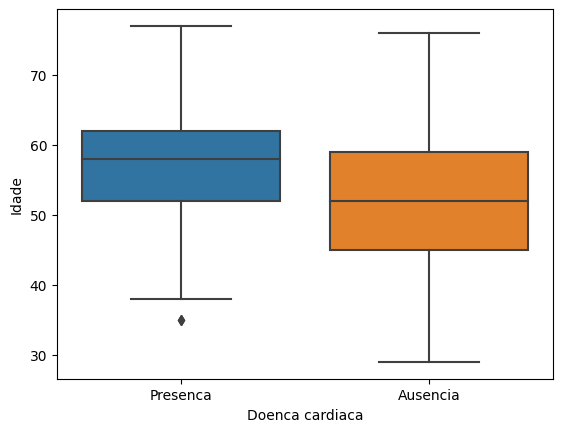

In [181]:
import seaborn as sns

sns.boxplot(df, x='Doenca cardiaca', y='Idade');

Vemos a presença da doença numa faixa entre 40 e 80 anos aproximadamente, com concentração entre 50 a 60 anos aproximadamente e mediana próxima de 60 anos. Os dados para ausência indicam uma amplitude maior da idade, com concentração entre 45 a 60 anos aproximadamente e mediana um pouco acima dos 50 anos.

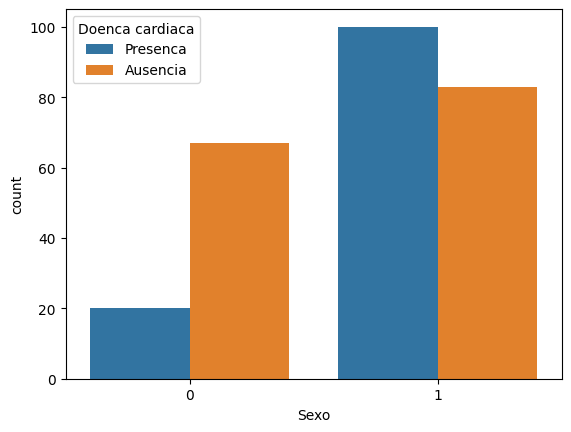

In [182]:
sns.countplot(df, x='Sexo', hue='Doenca cardiaca', );

In [183]:
df['Sexo'].value_counts(normalize=True)

1    0.677778
0    0.322222
Name: Sexo, dtype: float64

Um dado interessante é a presença de doença cardíaca de modo muito mais expressivo em pessoas do sexo masculino. Temos que levar em conta, no entanto, a distorção na distribuição de pessoas do sexo masculino (68%) com relação à do sexo feminino (32%).

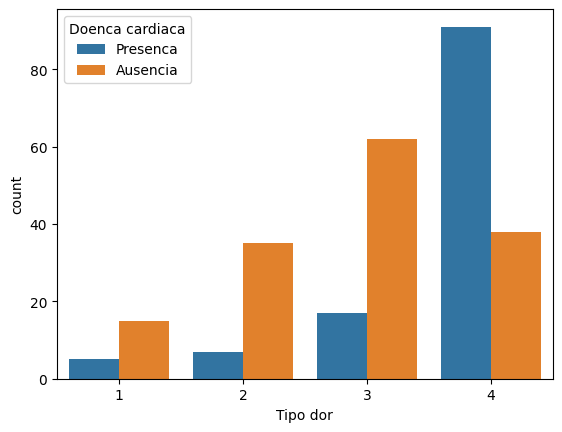

In [184]:
sns.countplot(df, x='Tipo dor', hue='Doenca cardiaca');

In [185]:
df['Tipo dor'].value_counts(normalize=True)*100

4    47.777778
3    29.259259
2    15.555556
1     7.407407
Name: Tipo dor, dtype: float64

A dor no Tipo 4 é uma característica muito significante para indicar a presença de doença cardíaca. Ainda assim, temos que levar em conta sua proporção nos dados levantados (47,8%), sendo que a dor tipo 1, por exemplo, está em 7,5% dos dados.

Verificando o gráfico para as outras colunas:

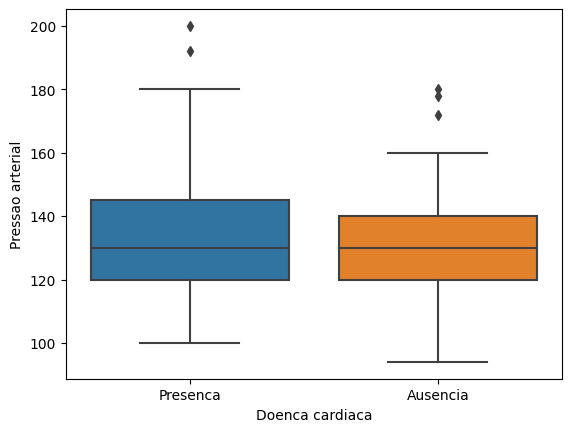

In [186]:
sns.boxplot(df, x='Doenca cardiaca', y='Pressao arterial');

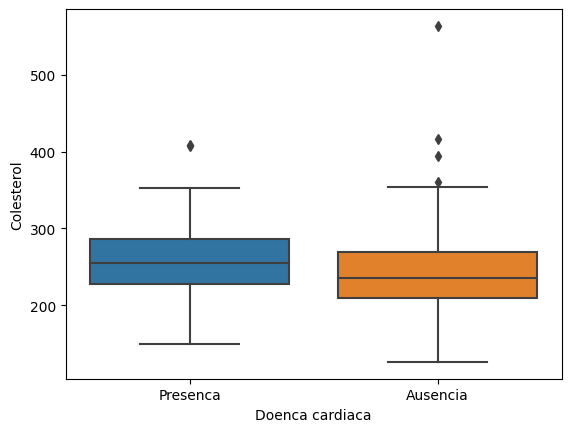

In [187]:
sns.boxplot(df, x='Doenca cardiaca', y='Colesterol');

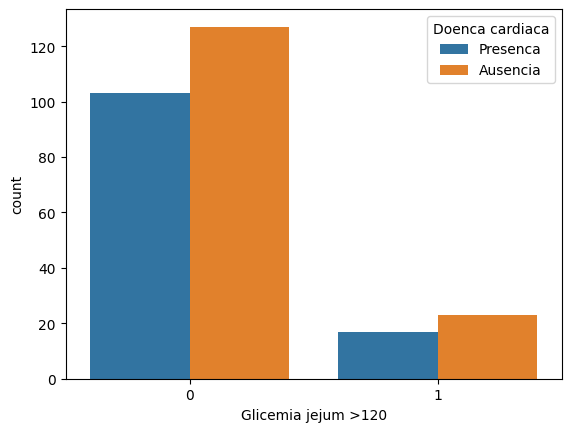

In [188]:
sns.countplot(df, x='Glicemia jejum >120', hue='Doenca cardiaca');

A coluna de nível de glicemia não parece trazer informação relevante.

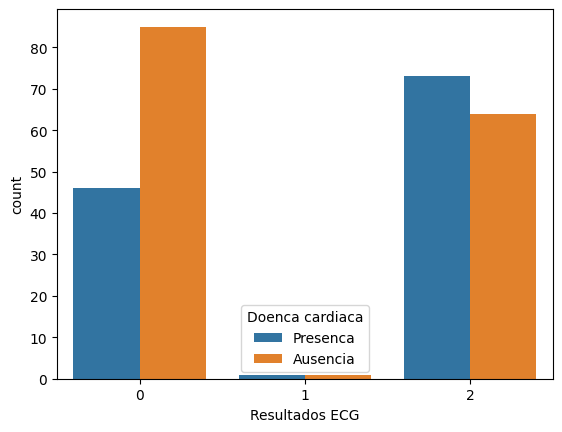

In [189]:
sns.countplot(df, x='Resultados ECG', hue='Doenca cardiaca');

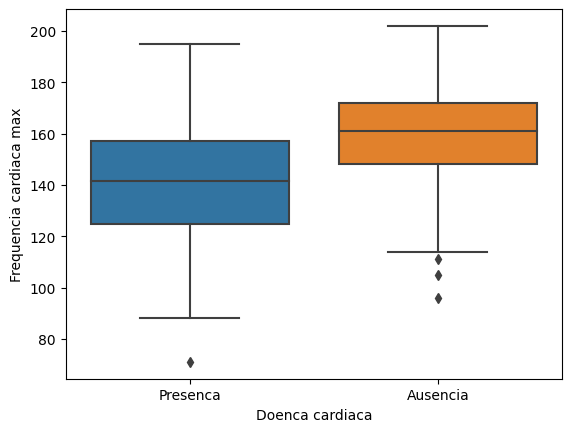

In [190]:
sns.boxplot(df, x='Doenca cardiaca', y='Frequencia cardiaca max');

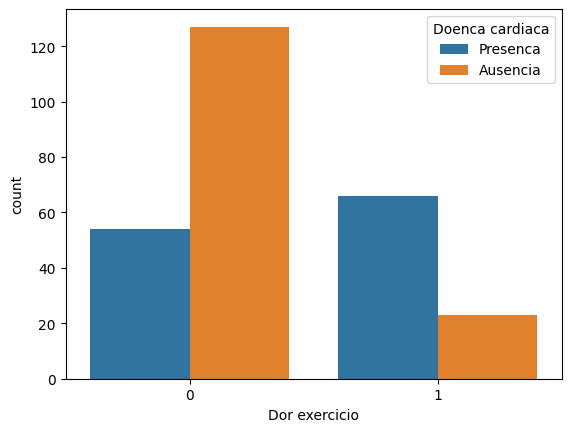

In [191]:
sns.countplot(df, x='Dor exercicio', hue='Doenca cardiaca');

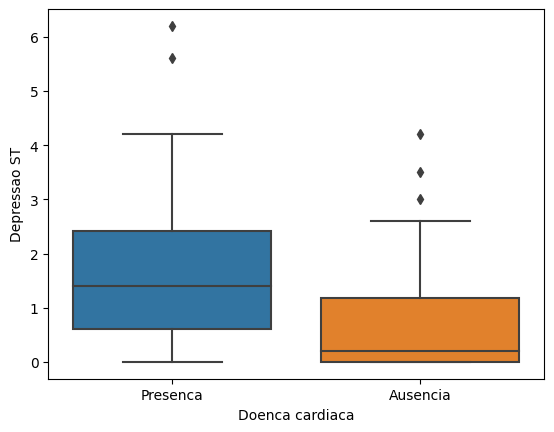

In [192]:
sns.boxplot(df, x='Doenca cardiaca', y='Depressao ST');

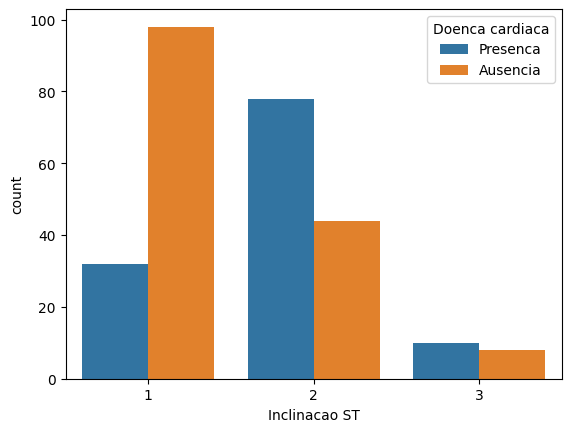

In [193]:
sns.countplot(df, x='Inclinacao ST', hue='Doenca cardiaca');

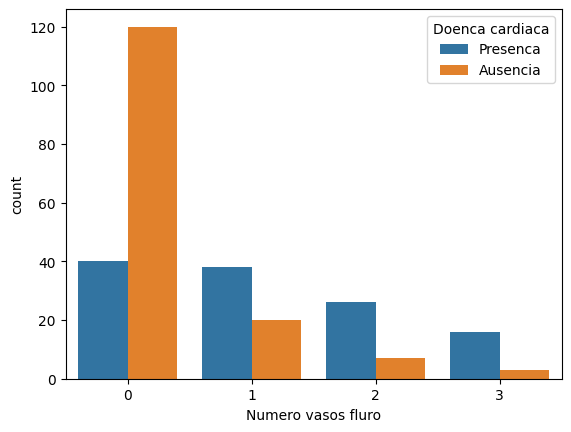

In [194]:
sns.countplot(df, x='Numero vasos fluro', hue='Doenca cardiaca');

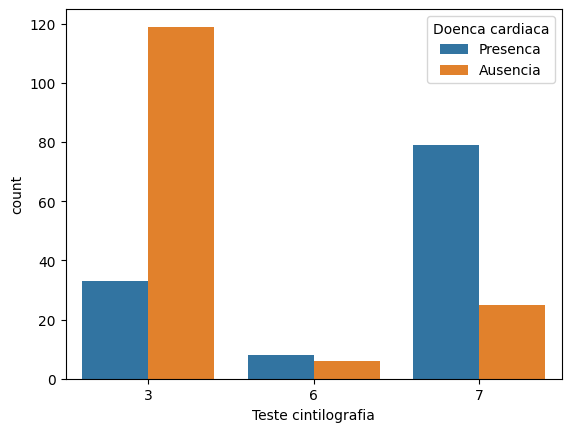

In [195]:
sns.countplot(df, x='Teste cintilografia', hue='Doenca cardiaca');

Verificando o target:

In [196]:
df['Doenca cardiaca'].value_counts()

Ausencia    150
Presenca    120
Name: Doenca cardiaca, dtype: int64

Os dados do target estão relativamente balanceados. Seu tipo, no entanto, está como Object (como visto em `df.info()`), por trazer valores em string. Para o uso do XGBoost, é necessário que a **coluna alvo seja do tipo numérico**, então iremos fazer a transformação dela.

In [197]:
df['Doenca cardiaca'] = df['Doenca cardiaca'].map({
    'Ausencia': 0,
    'Presenca': 1
})

In [198]:
df['Doenca cardiaca'].value_counts()

0    150
1    120
Name: Doenca cardiaca, dtype: int64

## Separação dos dados

Ao invés do método `drop`, podemos separar os dados usando o `iloc`. Também podemos atribuir valores a mais de uma variável em uma linha, separando os comandos por vírgula.

In [199]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [200]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

## Modelagem

### Modelo com árvore de decisão

O XGBoost é baseado em árvores de decisão. Então vamos primeiro implementar um modelo com uma árvore de decisão para podermos fazer comparações com um modelo com XGBoost, para entendermos o que ele faz de diferente e como melhora o modelo.

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [153]:
y_pred = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred)
print(f'Acurácia com decision tree: {acc_dt*100:.2f}%')

Acurácia com decision tree: 75.93%


In [154]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Ausencia', 'Presenca']))

              precision    recall  f1-score   support

    Ausencia       0.81      0.73      0.77        30
    Presenca       0.70      0.79      0.75        24

    accuracy                           0.76        54
   macro avg       0.76      0.76      0.76        54
weighted avg       0.77      0.76      0.76        54



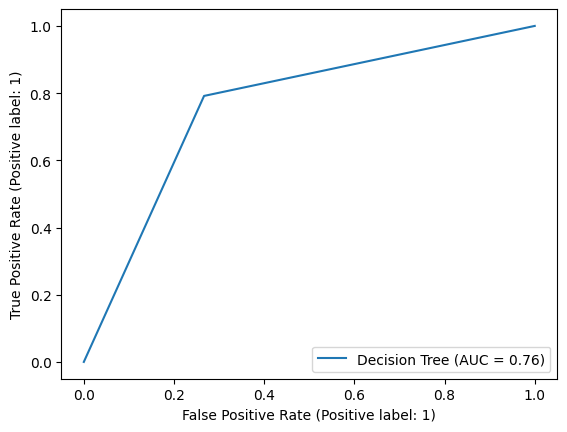

In [155]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred, name='Decision Tree');

### Modelo com XGBoost

eXtreme Gradient Boost. É uma biblioteca fora do sklearn (`pip install xgboost`).

Modelo que ficou muito famoso por ter sido usado em competições do Kaggle.

É composto por várias árvores de decisão (mais especificamente, árvores CART - Classification and Regression Trees, em que, ao invés de termos classes nos nós folha, temos um score indicando a probabilidade da classe positiva). As árvores são treinadas uma por vez, com a seguinte procurando melhorar onde a anterior não foi bem. 

Em seu uso, devemos informar no parâmetro `objective` se iremos trabalhar com classificação binária ou multiclasse. Com o `objective='binary:logistic'`, estamos informando que o problema é para classificação binária (training goal) utilizando uma função de perda logística (training_goal:loss_function). As folhas representarão um valor de pontuação em cada árvore, que são somados para obter a previsão final (mas não entendi como essa soma indica a classe. Eu acho que, por ser indicado "logistic", os valores são a probabilidade da classificação ser 1 (positiva), mas por ser soma não corre o risco de passar de 1?).

In [156]:
import xgboost as xgb

xg_model = xgb.XGBClassifier(objective='binary:logistic')
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

(Sim, são vários hiperparâmetros... é comentado sobre eles mais para frente no curso. Na [documentação do XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html) é possível ver detalhes de cada um.)

In [157]:
y_pred = xg_model.predict(X_test)
acc_xg = accuracy_score(y_test, y_pred)
print(f'Acurácia com XGBoost: {acc_xg*100:.2f}%')

Acurácia com XGBoost: 81.48%


Usando o Google Colab, podemos visualizar uma das árvores de decisão com a função `plot_tree` do XGBoost, com o parâmetro `num_trees` para escolher a árvore. No Visual Studio não rodou, provavelmente tem que instalar o Graphviz no Windows para rodar, então fiz o teste no Google Colab e salvei a árvore em um [arquivo png](plot_tree_google_colab.png). Se estiver rodando este notebook no Colab, o código abaixo pode ser descomentado para plotagem da árvore.

In [158]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 5), dpi=300)

# # plotting the 4th tree
# xgb.plot_tree(xg_model, num_trees=3, ax=plt.gca())
# plt.show()

In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54



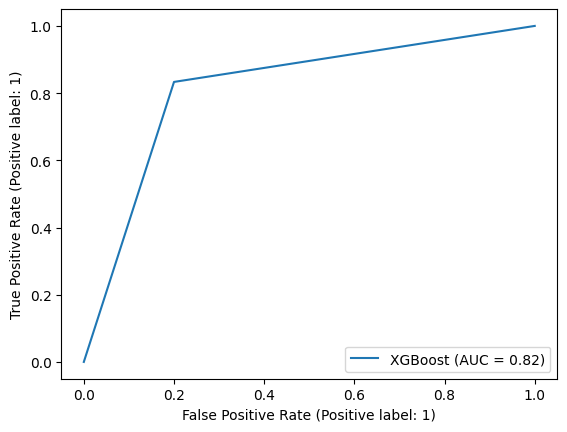

In [160]:
RocCurveDisplay.from_predictions(y_test, y_pred, name='XGBoost');

Comparando as duas curvas ROC:

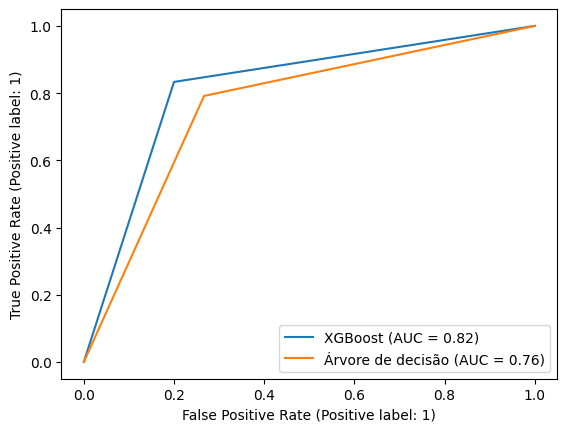

In [161]:
roc_xg = RocCurveDisplay.from_predictions(y_test, y_pred, name='XGBoost')
roc_dt = RocCurveDisplay.from_predictions(y_test, dt.predict(X_test), name='Árvore de decisão', ax=roc_xg.ax_)

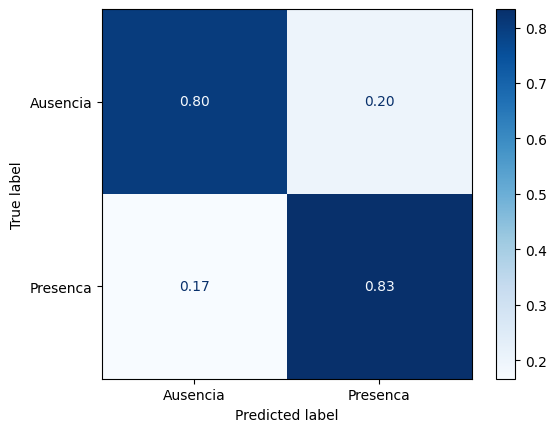

In [162]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Ausencia', 'Presenca'], normalize='true', values_format='.2f', cmap='Blues');

# you can also use from_estimator
# ConfusionMatrixDisplay.from_estimator(xg_model, X_test, y_test, display_labels=['Ausencia', 'Presenca'], normalize='true', values_format='.2f', cmap='Blues');

Quando trabalhamos com ML na área médica, o ideal é **minimizar os falsos negativos** (quando o classificador diz que a pessoa não tem a doença, sendo que ela tem).

## Validação cruzada com XGBoost

Para garantirmos uma métrica com resultados consistentes, podemos fazer a validação cruzada com o modelo implementado com o XGBoostClassifier. A biblioteca XGBoost possui seu próprio método de validação cruzada, com algumas diferenças quando comparado com a solução do sklearn, que pode ser vista nos comentários do código abaixo.

Como nosso dataset é pequeno (270 entradas), iremos passar todos os dados para a validação cruzada (lembrando que o mais correto é passarmos somente os dados de treinamento).

In [163]:
dmatrix = xgb.DMatrix(data=X, label=y) # optimized matrix structure for xgboost

params = {'objective': 'binary:logistic'} # params for the xgboost method in the cv method

cv_results = xgb.cv(
    dtrain=dmatrix,
    params=params,
    nfold=3, # number of folds in the cv
    num_boost_round=5, # number of iterations (a new tree is added on each boost round)
    # error is the commom used metric in xgboost classifiers. It's the ratio of incorrectly classified data points to the total number of data points, thus it's (1 - accuracy). 
    metrics='error',
    as_pandas=True, # results are returned as a DataFrame
    seed=123 # same as random_state in sklearn
)

cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.138889,0.023570,0.288889,0.055184
1,0.081481,0.010476,0.262963,0.010476
2,0.068519,0.013858,0.248148,0.037771
3,0.050000,0.007857,0.229630,0.010476
4,0.046296,0.010476,0.222222,0.018144


Cada linha traz os resultados para cada boost round.

A acurácia é o complemento do erro (1-error), então podemos também obter essa métrica, levando em conta o último boost round:

In [164]:
print(f'Acurácia com validação cruzada: {1-cv_results["test-error-mean"].iloc[-1]}')

Acurácia com validação cruzada: 0.7777777777777778


### Parada antecipada da validação cruzada

Aumentar o número de rounds não significa uma melhoria contínua da métrica. Pode ocorrer inclusive o overfitting. Podemos utilizar o parâmetro `early_stopping_rounds` para definir uma condição de parada antecipada da validação caso não haja melhoria significativa do modelo (no conjunto de **teste**). Com esse parâmetro, mesmo se colocarmos um número alto de `num_boost_round`, a validação para se não houver a melhoria. Essa verificação de melhoria é feita a cada X rounds, número definido pelo valor passado ao `early_stopping_rounds`. É verificado se houve pelo menos uma melhoria na métrica; se não houver, a validação para. Caso a condição de parada seja atingida, serão mostrados os resultados obtidos até o round com o melhor valor da métrica.

In [165]:
cv_results = xgb.cv(
    dtrain=dmatrix,
    params=params,
    nfold=3, # number of folds in the cv
    # error is the commom used metric in xgboost classifiers. It's the ratio of incorrectly classified data points to the total number of data points. 
    metrics='error',
    as_pandas=True, # the result is returned as a DataFrame
    seed=123, # same as random_state in sklearn
    num_boost_round=50, # increasing the number to check what happens when early stop is added
    early_stopping_rounds=5, # check if cv should stop at every 5 rounds
)

print(f'Acurácia com validação cruzada: {1-cv_results["test-error-mean"].iloc[-1]}')

Acurácia com validação cruzada: 0.7925925925925926


In [166]:
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.138889,0.023570,0.288889,0.055184
1,0.081481,0.010476,0.262963,0.010476
2,0.068519,0.013858,0.248148,0.037771
3,0.050000,0.007857,0.229630,0.010476
4,0.046296,0.010476,0.222222,0.018144
5,0.033333,0.013608,0.214815,0.013858
6,0.024074,0.006929,0.207407,0.013858


## Ajustando hiperparâmetros

Vamos ajustar 4 hiperparâmetros relacionados às árvores da técnica:

- `eta` (ou `learning_rate`): é a taxa de melhoria do modelo (default=0.3). Taxas de aprendizado mais baixas requerem mais iterações para alcançar a mesma redução de erro, enquanto taxas mais altas podem acelerar o processo;

- `max_depth`: profundidade de cada árvore (default=6). Árvores mais profundas correm o risco de aumento de overfitting;

- `n_estimators`: número de árvores. É o mesmo que `num_boost_round` que aparece no método `cv`, só muda o nome;

- `colsample_bytree`: proporção de features (colunas) usadas na árvore (default=1, ou seja, 100%).


Testando a técnica com valores diferentes do default:

In [167]:
params = {
    'objective':'binary:logistic', 
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5
}

cv_results = xgb.cv(
    dtrain=dmatrix,
    params=params,
    nfold=3, 
    num_boost_round=100, 
    early_stopping_rounds=5,
    metrics='error',
    as_pandas=True, 
    seed=123
)

print(cv_results)
print(f'Acurácia: {1-cv_results["test-error-mean"].iloc[-1]}')

    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.353704         0.103869         0.414815        0.108992
1           0.274074         0.087528         0.377778        0.118634
2           0.225926         0.094426         0.314815        0.099519
3           0.150000         0.061027         0.255556        0.080635
4           0.137037         0.049759         0.233333        0.063505
5           0.122222         0.020787         0.218519        0.057616
6           0.105556         0.024003         0.218519        0.042873
7           0.100000         0.016355         0.222222        0.039545
8           0.098148         0.005238         0.207407        0.036665
9           0.096296         0.006929         0.200000        0.036289
10          0.088889         0.007857         0.203704        0.027716
11          0.090741         0.002619         0.203704        0.027716
12          0.081481         0.006929         0.192593        0.027716
Acurác

### Ajuste com Random Search

In [168]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'colsample_bytree': [0.1, 0.5, 1],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [0, 2, 4, 6, 10],
    'n_estimators': [10, 25, 50]
}

model_xgb = xgb.XGBClassifier()

random_search_cv = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=params,
    n_iter=5,
    cv=4,
    scoring='accuracy',
    verbose=1 # show a bit of info for each iteration
)
random_search_cv.fit(X, y)

print('Melhores parâmetros encontrados:', random_search_cv.best_params_)
print('Acurácia:', random_search_cv.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


Melhores parâmetros encontrados: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.5}
Acurácia: 0.8223770851624231


### Ajuste com o Grid Search

In [213]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [0, 2, 4, 6, 10],
    'colsample_bytree': [0.1, 0.5, 1],
    'n_estimators': [10, 25, 50]
}

model_xgb = xgb.XGBClassifier()

grid_search_cv = GridSearchCV(
    estimator=model_xgb,
    param_grid=params,
    cv=4,
    scoring='accuracy',
    verbose=1
)

grid_search_cv.fit(X, y)

print('Melhores parâmetros encontrados:', grid_search_cv.best_params_)
print('Acurácia:', grid_search_cv.best_score_)

Fitting 4 folds for each of 135 candidates, totalling 540 fits
Melhores parâmetros encontrados: {'colsample_bytree': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Acurácia: 0.8556299385425812


Curiosamente, no Google Colab, o melhor valor para o hiperparâmetro `colsample_bytree` é 1 e não 0.1, como encontrado aqui. Vou usar 1 para seguir a aula, mas se ajustar a próxima seção com 0.1, os resultados encontrados são **piores**.

## Modelo com melhores hiperparâmetros

Iremos ajustar um modelo com os melhores valores de hiperparâmetros encontrados pelo Grid Search.

Acurácia: 0.8518518518518519
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.81      0.88      0.84        24

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



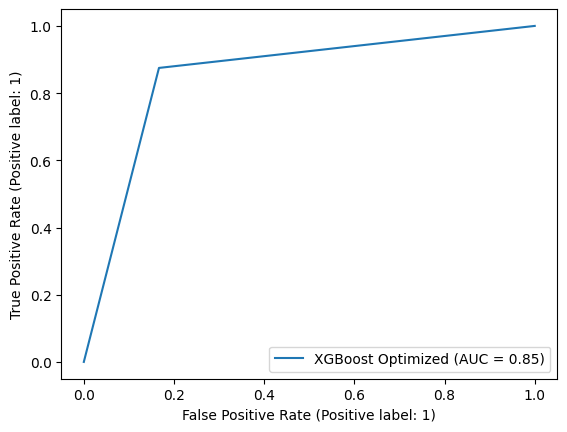

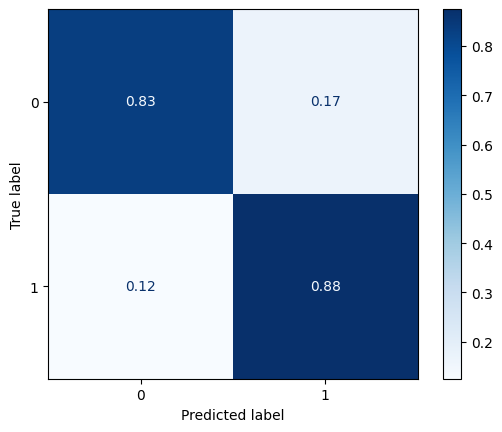

In [215]:
xg_model_optimal = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=1, learning_rate=0.1, max_depth=2, n_estimators=50)

xg_model_optimal.fit(X_train, y_train)

y_pred = xg_model_optimal.predict(X_test)

print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred, name='XGBoost Optimized')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format='.2f', cmap='Blues');

Podemos observar que o recall para a classe 1 aumentou para 0.88, o que por consequência faz com que a taxa de falsos negativos tenha diminuído, o que era nosso objetivo.

## Simulando situação de produção

Em uma situação real, colocando um modelo em produção, uma alternativa é encapsular todos os passos (steps) em um pipeline, desde a transformação dos dados até a criação do modelo. Você pode então utilizar a pipeline em métodos como o GridSearchCV ou em uma validação cruzada, para que todos os passos da pipeline sejam executados em sequência. 

Quando é necessário passar parâmetros para um dos passos do pipeline, você diferencia os parâmetros de cada passo com a nomenclatura `nome_do_passo__nome_do_parametro`.

No caso da aula, para mostrar o uso do pipeline, será criado um pipeline para fazer o grid search novamente. Como somente temos o modelo, o pipeline só tem esse passo de instanciar um modelo padrão.

In [242]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('xgboost', xgb.XGBClassifier())])

param_grid = {
    'xgboost__learning_rate': [0.1, 0.2, 0.3],
    'xgboost__max_depth': [0, 2, 4, 6, 10],
    'xgboost__colsample_bytree': [0.1, 0.5, 1],
    'xgboost__n_estimators': [10, 25, 50]
}

grid_search_cv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=1
)

grid_search_cv.fit(X, y)

print(f'Acurácia: {grid_search_cv.best_score_}')
print(f'Melhor modelo (estimador): {grid_search_cv.best_estimator_}')

Fitting 4 folds for each of 135 candidates, totalling 540 fits
Acurácia: 0.8556299385425812
Melhor modelo (estimador): Pipeline(steps=[('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
          

Novamente, vale a observação de que no VS Code colsample_bytree=0.1 e no Colab colsample_bytree=1.

Outro passo em produção é salvar o modelo em um arquivo, para poder ser usado em outras aplicações:

In [217]:
import joblib

joblib.dump(grid_search_cv.best_estimator_, 'modelo_pipeline.pkl')

['modelo_pipeline.pkl']

Agora suponha que estamos em outra aplicação e queremos utilizar o modelo para análise de dados de 10 novos pacientes. Iremos carregar o modelo e passar estes novos dados a ele para classificação:

In [220]:
model = joblib.load('modelo_pipeline.pkl')

In [237]:
new_data = pd.read_csv('pacientes_novos.csv')
new_data

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia
0,41,1,4,110,172,0,2,158,0,0.0,1,0,7
1,45,0,4,102,265,0,2,122,0,0.6,2,0,3
2,50,1,3,130,246,1,2,173,0,0.0,1,3,3
3,52,0,4,100,248,0,2,122,0,1.0,2,0,3
4,54,0,3,110,214,0,0,158,0,1.6,2,0,3
5,70,0,1,140,239,0,0,151,0,1.8,1,2,3
6,42,0,4,132,341,1,2,136,1,3.0,2,0,7
7,34,0,1,150,283,1,2,162,0,1.0,1,0,3
8,52,1,1,118,186,0,2,190,0,0.0,2,0,6
9,35,1,4,112,245,0,0,150,0,1.0,2,2,3


Obtendo as classificações:

In [238]:
predictions = model.predict(new_data)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Resultado no Colab: array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1])

Além das classificações, podemos também verificar a probabilidade encontrada para cada entrada. A função predict_proba irá retornar uma lista, em que cada elemento representa uma entrada, e é formado por outra lista, esta com os valores de probabilidade para cada classe.

In [225]:
probabilities = model.predict_proba(new_data)
probabilities

array([[0.58121014, 0.41878983],
       [0.8048301 , 0.19516991],
       [0.75023687, 0.24976315],
       [0.69186294, 0.30813703],
       [0.8292472 , 0.17075284],
       [0.6441561 , 0.35584393],
       [0.2054686 , 0.7945314 ],
       [0.73751175, 0.26248822],
       [0.7706282 , 0.22937179],
       [0.5197649 , 0.48023507]], dtype=float32)

Resultado no Colab: 
```python
array([[0.47394192, 0.5260581 ],
       [0.8558974 , 0.14410257],
       [0.73324203, 0.26675797],
       [0.7878467 , 0.21215333],
       [0.95727295, 0.04272704],
       [0.8929907 , 0.10700932],
       [0.09207231, 0.9079277 ],
       [0.8851794 , 0.11482063],
       [0.9037258 , 0.0962742 ],
       [0.20894748, 0.7910525 ]], dtype=float32)
```

In [226]:
new_data_with_predictions = pd.DataFrame(new_data)
new_data_with_predictions['Previsao'] = predictions
new_data_with_predictions

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,Previsao
0,41,1,4,110,172,0,2,158,0,0.0,1,0,7,0
1,45,0,4,102,265,0,2,122,0,0.6,2,0,3,0
2,50,1,3,130,246,1,2,173,0,0.0,1,3,3,0
3,52,0,4,100,248,0,2,122,0,1.0,2,0,3,0
4,54,0,3,110,214,0,0,158,0,1.6,2,0,3,0
5,70,0,1,140,239,0,0,151,0,1.8,1,2,3,0
6,42,0,4,132,341,1,2,136,1,3.0,2,0,7,1
7,34,0,1,150,283,1,2,162,0,1.0,1,0,3,0
8,52,1,1,118,186,0,2,190,0,0.0,2,0,6,0
9,35,1,4,112,245,0,0,150,0,1.0,2,2,3,0
